 <center><font size="6">Welcome to my detectron2 notebook.

I am an undergraduate student working on a research project at my university. As part of my responsibilities, I was asked to find a method for removing a 'dynamic' background in a set of videos which include animals, leaving behind only the animals. After searching around for solutions, including how make the [matterport Mask R-CNN](https://github.com/matterport/Mask_RCNN) code work natively on my Mac M1, I stumbled upon a [youtube video](https://www.youtube.com/watch?v=9a_Z14M-msc) explaining how to work with detectron2. Detectron2 was immediately appealing and made me realize that the problem statement I was working with needed to be adjusted. I mentally changed my assignment to "given a video with animals in it, return only the animals without any other background content." This may sound the same as my original assignment, but to me, the subtle difference in thought process was significant. So I decided to train and use detectron2 as the base for identifying the animals in my videos, creating instance masks, extracting the animals from videos based on these masks, pasting them onto a blank canvas, and then ultimately saving the newly constructed canvas as a video frame in a new video.  

This notebook includes information from many sources, which I pulled together quickly, mainly over a Christmas break. Therefore, let me know if you see some of your code here without acknowledgment as I am happy to include a reference. 

I have included the lessons and methods I learned during this process, even if they were not strictly related to my original goal. I spent **A LOT** of time researching solutions to what seemed like simple problems with detectron2 and Colab, which ultimately required rather complex solutions. I sincerely hope this notebook helps someone else save time in the future! If you find something I am missing, let me know and I'll include it as I have time.

Within this notebook, I will: 

1.   Explain how to get your dataset ready to train your model. 
2.   Give the code required to train your model, including the flexibility to train an individual thing, or many things, automagically with a simple change to configuration parameters. 
3.   Create inference output with images using your new model.
4.   Create a set of videos to demonstrate the masking capabilities of this notebook.<font color='red'>*</font>

Problems I had to solve:
1.  Hacking together a static version of the core training/inference code was relatively easy. Making it generic so that I/you can make zero/minimal code changes and train 1 to N classes, took a lot of effort. This was the main reason I have this notebook's Global Variables at the start of code sections. Make sure you understand these variables and their usage before modifiying the code in the notebook. 
2. I only found 1 sample of code explaining how to take an instance mask and use it to get only that object back out of an image. I adapted that code and included it within thing_masker.get_masked_image(). More on that later.
3. I did not find any working examples of subclassing the default trainer to add the augmentations. One example was close to working, but its info needed to be completed. My functional example is shown below in the MyTrainer class. In addition, I have added the augmentation list to the Global Variables so that it can be easily modified for your purposes.
4. Auto-saving a newly created model out of colab. This may sound minor, but it is vital when trying to conserve compute credits. I saved a time/date marked version of the model and model configuration to my Google drive. At the end of the code, there is an auto-terminate function to delete the runtime and stop consuming credits. If no errors occur, you can connect the runtime, hit run-all, and walk away knowing that it won't waste your compute credits.
5. I could not find any *simple* method to display only the thing classes I wanted. The objective is that regardless of what was detected, only mask and highlight certain classes of things. All of the examples I read showed filtering to a single classes, but I implemented a method to filter N classes. This is done by recursively removing all detected things that are not in the un-ordered "my_display_things" list. Three lines of code accomplish what seemed very complex initially. 
6. I did not locate any complete examples of preparing a dataset from start to finish. The data preparation section of this doc may seem excessively detailed, but it comes from frustration at not finding a good tutorial.  
7. I will add more items here as I remember additional challenges I encountered and solved.    


Happy training!

<font size = '2' color='red'>*This was the actual goal of my work when I started.</font>

# Before You Begin
---

## Preparing Your Dataset

Every tutorial I have read for detectron2, and machine vision in general, waves its virtual hands and says, "make sure to prepare and annotate your images properly." Below I explain exactly how I prepared and annotated the images. I have included everything that seemed critical without being overly verbose. 

### Find and Resize Your Images

I needed to acquire and annotate images of rats and larvae. To acquire the larva images, I leveraged some videos we had from our lab. I extracted a variety of frames from differing sets of videos and stored them for processing. Acquiring quality rat images proved more difficult. First, I downloaded as many as I could find from the internet. Then I grabbed a few out of adobe stock. Image acquisition will always be a hurdle to improving detection quality if this project is taken forward. 

Now that I had the images, I needed to prepare them. For training, the images must be the same size. I chose 1024x768, but it could have been any size. This size intuitively seemed large enough for the detail I needed yet small enough for reasonably fast training. I have seen code that automagically does this resizing, but it seemed overly complex for my initial experiment.<font color='red'>*</font> So instead, I processed them manually with Adobe Photoshop with the following steps:

1. Use File->scripts->"image processing" and then "Resize to fit" 1024x768, as shown in Figure 1 below. If you pay attention, you will notice that this did not blindly resize the image. Instead, it made it as proportionally big as possible while still fitting within 1024x768.

2. Make all of the images ACTUALLY 1024x768 by increasing the 'canvas' size of the image. Image->CanvasSize->1024x768, as shown in Figure 2 below. 
You can perform this action individually on the images or create a custom action and batch-apply it to images.<font color='green'>**</font> 


Once you have performed these actions, the images will be sized 1024x768 with their original proportions and black padding around any dimension smaller than the target size. 

___
<font color='red' size='2'>*If you choose to integrate this functionality, you must create a custom dataloader extending the integrated coco dataloader.  Remember that the annotations must also be resized and located. This would be useful, just outside my scope. </font>

<font color='green' size='2'>** ProTip: I did it with a custom action inside Photoshop. If you record an action, first open an image that needs its height modified and record expanding the canvas height. Then stop recording and open an image that needs its width modified. Open your action and record the expansion of the canvas for the width as an additional step. Finally, record the save function. Your custom action should look similar to Figure 3. Make sure the steps mirror what is in Figure 3. CHECK THE IMAGE SIZES BEFORE ANNOTATION.  If you have to resize any images, you must redo the annotations.  That is a massive waste of time. </font>

Figure 1: Image Processing Screen

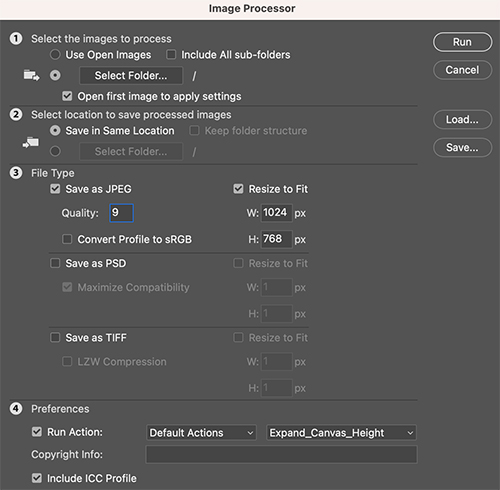
___

Figure 2: Canvas Size Screen

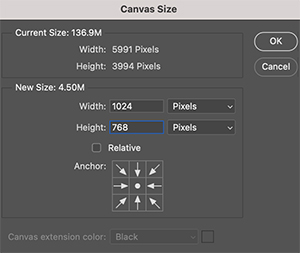
___

Figure 3: Photoshop Custom Action to Resize Canvas

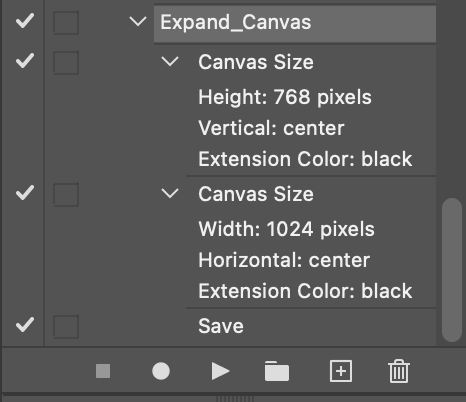

___

### Annotate Your Images

#### Create the Project and Task(s)

For image annotation, I <font color="red">HIGHLY</font> recommend the online version of [CVAT](https://app.cvat.ai/). It is free to use, and the only downside I have found so far is that you can only have three projects in the free version. However, that is plenty for my purposes because you can also save/update image-annotation pairs. Provided that you are organized with your local dataset storage, it is easy to rotate in and out projects by re-uploading the images, setting up the labels in the project just like the original, and uploading the existing annotations. Therefore, for my annotating tasks, I used CVAT and exported it to "COCO 1.0" format for simplicity<font color='green'>*</font>. 

To start, create a project and add the labels you want, as shown in Figure 4. 

For my project, I used polygons for the annotation type as shown in Figure 5.

Then create a new Task, as shown in Figure 6. Upload all of the images that you want to annotate. After creating the task, open it and start annotating!
___
<font color='green' size='2'>*Detectron2 includes a COCO format dataloader. Therefore, using the COCO 1.0 format makes it very easy to import the annotations.</font>


Figure 4: Create a Project and Create Needed Labels

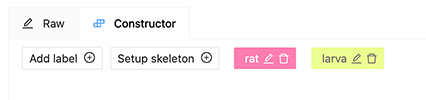
___

Figure 5: Create the needed labels

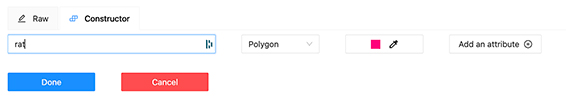
___

Figure 6: Create New Task

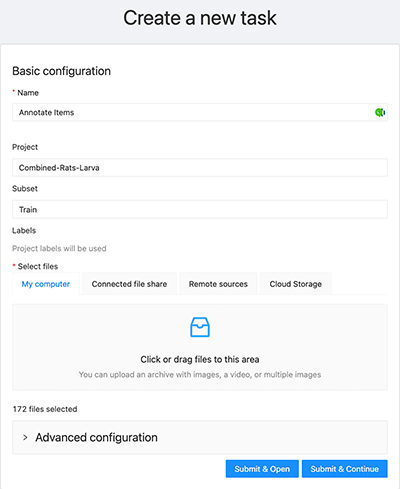
___

#### Draw the annotations

Now it is time to draw on your image. Fun, right? Not exactly. It is incredibly monotonous. I look forward to the day when I can outsource this to some unsuspecting undergrad ;)

The first way to label is by selecting the pentagon shape on the left side toolbar and adding points around the object you want to capture. Next, make the polygon points fit the object closely by zooming in/out and moving around in the image. 

<font size="2">ProTips:</font>

*  <font size='2'>'N' starts/ends an annotation</font>
*  <font size='2'>'F' goes to the next image</font>
*  <font size='2'>{Fn}{Del} completely deletes the highlight annotation on my Mac. I deleted and re-annotated many times and got sick of using the menus to delete. So that you know, the key-combo CVAT suggests didn't work on my Mac.</font>
*  <font size='2'>To quickly draw a LOT of points, press 'N' to start a new polygon as usual. Then hold the {shift} key and move the mouse over the object's edge. It will {auto-draw} points as if you repeatedly click the mouse button. You can let go of the {shift} key, reposition the cursor or mouse, and then press the {shift} key to add more points. Terminate the polygon by presssing 'N' again. You should note that the more zoomed into the image you are, the more actual points it adds. I have included an example below to show the difference in the quality of annotation. *In theory,* you could produce the same results manually clicking each point, but you would quickly end up with a repetitive stress injury. Play around with this capability. It is quite useful.</font>
*  <font size='2'>If you want to get fancier, I would suggest using the magic wand tool on the left toolbar but remember: ensure that "convert masks to polygons" is on, as shown in Figure 7! The HRNET and F-BRS algorithms worked best for me. If you are going to use these tools, go slowly. Click within the object, wait to see the result, and then click again if needed. After it makes the majority of the shape, go to an area that needs refinement and {shift}{click} on a point. Then add a new line segment. You must {click} on an existing point to terminate that new line segment. The behavior is sometimes unexpected as it selects which part of the polygon to keep. If it flashes back and forth between to colors (red and blue in my case), it is asking you to tell it which shape you intended to make. {Click} the one you want.   
*  <font size='2'>My magic mouse with my Mac was a nightmare. The zooming on the mouse would engage when I least expected it. I went into the System Setting -> accessibility->pointer control->mouse option and disabled "use mouse for scrolling." Then I used my left hand on the trackpad to zoom in/out and the magic mouse just for annotating.</font>

Make sure to save your work as you complete annotation of an image. It is better to save too often rather than risk the furstration of accidentally closing the browser window without saving your work! *I do not want to talk about why I know this is frustrating.*

Before:

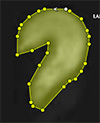

After using the continuos point method:

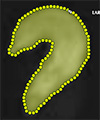

___

Figure 7: Magic Wand

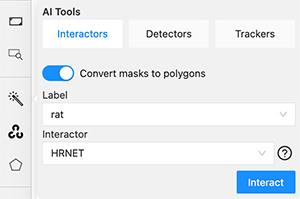
___

####Export Your Annotations

Once you finish your annotations, go back to the projects page. Hover over the three vertical dots in the lower right corner of your project and click "Export Dataset."  Then select "COCO 1.0" format, give the file a name, and click download. This final screen is shown in Figure 8. 

Once this file downloads, you will notice it is a zip file. Once extracted, it will contain up to three annotation files: One for training, one for testing, and one for validation.  If you have only created a single training annotation set, it will only have a single file inside the zip. 

Move the annotation file(s) to the proper folder within your dataset and then you are ready to train!

Figure 8: Annotation Export

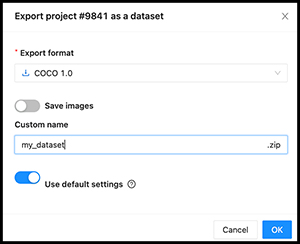

___

## Setup Your Dataset Directory Structure in Google Drive

You <font color="red">must</font> follow the dataset directory structure shown below, or you will need to change your code. First, I put the datasets' root at the root of my google drive for simplicity. Then I put each dataset inside a folder as shown below:

    GoolgeBase (aka: MyDrive)
        |
        datasets
            |
            my_dataset_path
                |
                train
                  |
                  {your_training_images}
                |
                test
                  |
                  {your_test_images}
                |
                annotations
                  |
                  {your_annotation_files}
                |
                videos
                  |
                  {your_video_files (mp4, mov, avi only}
                videos_output
                  |
                  {your_video_processing_results_will_go_here}
                |
                models
                  |
                  {timestamped_model_copies_stored_here}
                |
                logs {auto-created}
                  |
                  {training logs go here}
                |
                sys {optional}
                  |
                  {any local libraries, functions, etc.,}

___

# Setup the Notebook and Install Detectron2 (v0.6)
---



##Running Local?

Altough I don't explain within this notebook how to run this notebook using a local 'kernel', it is possible. I have had mixed results so I would recommend just running it in Colab. If you do choose to run it locally on your computer, change the "local" variable to "True". These flags won't change very often so they are here on their own. If you run this notebook outside of Google Colab, change:
1.  "local=True" to prevent simple errors due to importing google modules, trying to kill the notebook to save credits, etc. 
2. Change the nvidia_alt to match your local system

In [ ]:
local = False

# If torch for Mac M1/M2 starts to work, this will allow a quick switch.
# nvidia_alt = 'mps' 
nvidia_alt = 'cpu'

##Mount your Google Drive

These commands mount your google drive as '/content/drive' within your Colab notebook. Therefore, if you put your datasets within your google drive, they are easy to access while the notebook is active. 



In [ ]:
if not local: 
    from google.colab import drive
    drive.mount('/content/drive')

##Install pyyaml, torch, and torchvision 

Note: You will likely see an error for torchaudio and torchtext compatibility. You can safely ignore these messages for this project. 

In [ ]:
# Check which versions of pyyaml, torch, and torchvision are installed.
# If the versions you want are not installed, do it now.
# If they are installed, don't waste time downloading them.
pyyaml_version = !pip show pyyaml | grep Version
torch_version = !pip show torch | grep Version
torchvision_version = !pip show torchvision | grep Version

if local:
  print('running locally')
  print('pyyaml ' + pyyaml_version[0]+ ' installed') 
  print('torch ' + torch_version[0]+ ' installed')
  print('torchvision ' + torchvision_version[0]+ ' installed')
else: 
  !pip install pyyaml
  if torch_version[0] != 'Version: 1.10.1+cu113':
    !pip install torch==1.10.1+cu113 -f \
      https://download.pytorch.org/whl/torch_stable.html
  else:
    print('torch ' + torch_version[0] + ' already installed')
  if torchvision_version[0] != 'Version: 0.11.2+cu113':
    !pip install torchvision==0.11.2+cu113 -f \
      https://download.pytorch.org/whl/torch_stable.html
  else:
    print('torchvision ' + torchvision_version[0] + ' already installed')

##Install Detectron2

In [ ]:
# Check which version of detectron2 is installed.
# If the version I want is not installed, do it now.
# If it is installed, do not waste time downloading it. 
detectron2_version = !pip show detectron2 | grep Version

if local:
  print('detectron2 ' + detectron2_version[0] + ' installed')
else:
  if detectron2_version[0] != 'Version: 0.6+cu113':
    !python -m pip install detectron2==0.6 -f \
      https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
  else:
    print('detectron2 ' + detectron2_version[0] + ' already installed')

That is it. Your notebook should be all setup and ready to start understanding the world around it. 

## Get Info About Your Environment
---

In [ ]:
# If you are local, I assume you know your resources; Therefore, it does not
# run when you are operating locally
if not local:
    !nvidia-smi -L
    !lscpu |grep 'Model name'

#Import The Required Libraries
---

In [ ]:
# If you want to import modules stored in local files, you must add
# the directory storing the modules to the system path first.
# My suggestion is to create a "sys" directory within your dataset structure 
# and then add it to the path. For instance, you could put the thing_masker cell
# into a thing_masker.py file and store it separately. 
#
#import sys
#sys.path.append(my_dataset_path + my_dataset_name)
#sys.path.append(my_dataset_path + my_dataset_name + '/sys/')
#
# you could remove the thing_masker class from notebook and import it
# from thing_masker import thing_masker


import os
import time
import torch 
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime 
import shutil

from IPython.display import display
from IPython.display import Image as IPython_Image

# Import Detectron2 libraries.
from detectron2 import model_zoo, data
from detectron2.config import get_cfg, LazyConfig
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.colormap import random_color
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.engine.train_loop import weakref
from detectron2.data import DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.build import build_detection_train_loader

# This makes sure you get progress bars regardless of if you are 
# local or in Colab.
# It also enables the google colab imports only when running in Colab.
if local:
  from tqdm import tqdm as tqdm_notebook
else: 
  from tqdm.notebook import tqdm_notebook
  from google.colab.patches import cv2_imshow
  from google.colab import runtime

# Tell matplotlib to display within the notebook.
%matplotlib inline

# GPU support configuration.
# This line checks to see if you have cuda, apple mps, or just cpu.
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = nvidia_alt

#Set up Your Global Variables Here. <font color='red'>Run Every Time!</font>
---

In [ ]:
#
#  my_dataset_path = path to where all of your datasets are stored
#  my_things = ['thing1', 'thing2', etc.]
#  my_dataset_name = 'your_dataset_name'
#  my_training_annoation_name = "name_of_the_annotation_file_you_want_to_use"
#

#  my_dataset_path = path to where all of your datasets are stored.
my_dataset_path = '/content/drive/MyDrive/datasets/'

#  my_things = ['thing1', 'thing2', etc] are the things in the model. 
my_things = ['rat', 'larva',]


# my_display_things = ['thing1', 'thing2', etc.] are the things you want to 
# visualize. This should be everything in your model during training.  
# The output only includes items in this unordered list.
my_display_things = ['rat','larva',]

# my_prediction_threshold is a float <= 1.0 that defines the minimum
# prediction probability accepted as a valid result for the model output.
# If you are training for the first time, set this VERY low to see all
# detections. Refine as the model accuracy improves to ensure fewer false
# identifications.
my_prediction_threshold = 0.90

# Your folder name within "datasets" that you are storing your dataset info.
my_dataset_name = 'combo'

# Name of the annotation file to use for training. 
my_training_annotation_name = 'combo_annotations.json'

# Set the image and video file extensions you want to support for testing.
# The target testing directory will be searched for files with these extensions.
# My Mac stores .DS_Store files everywhere that cause issues unless I filter 
# them out! Out of nowhere, I get an empty image/tensor and spend FOREVER
# tracking down the source without this filter.
image_extensions = ['.jpg','.png',]
video_extensions = ['.mp4','.mov', '.avi',]


# Flag to train a new model and use it for inference.
# If this flag is false, you must have a model named 
# <dataset_name>_model_final.pth in your models directory or 
# inference will fail.   
train = True
stop_after_training = True

# List of augmentation used to train a new model. This is used within
# MyTrainer(). Read below about my success/failure using augs.
my_augmentations = [T.RandomRotation(angle=[0,90],sample_style="range"),
                    T.RandomBrightness(0.5,2),
                    T.RandomContrast(0.5,2),
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False)]


# How many iterations to train.
# FYI: with the parameters in this notebook and the dataset I provide,
# the model stops improving at approx 20,000 iterations. 
my_max_iterations = 100 # 20000

# I use 4 for Standard GPU (Tesla T4) and 8 for Premium (A100-40G). 
my_IMS_PER_BATCH = 4

# Flag causes the runtime to terminate and delete runtime at the end of   
# 'run all', if no errors occur, to save compute credits.
# Ensure you really want the runtime and all local info to be terminated.
disconnect_on_complete = True

# Train The Model
---

##<font size="4">Import Dataset

<font size='3'>

1. Import the annotations you made (coco format, polygon).
2. Register the dataset with the correct category name using the detectron2 coco dataloader.
3. Point the instance to the image directory.
4. If you are training, check that the 'things' inside the annotations match the 'things' you configured.

In [ ]:
# Import the images and annotations.

# Check if the dataset name is already registered. If so, remove.
# This shouldn't happen normally, but while debugging and running the notebook
# repeatedly, this happens so I decided to catch/fix it. 
if str(my_dataset_name + '_train') in DatasetCatalog.list():
    DatasetCatalog.remove(str(my_dataset_name + '_train'))

# Register the dataset.
register_coco_instances(str(my_dataset_name + '_train'), {}, \
                        str(my_dataset_path + my_dataset_name + \
                            '/annotations/' + my_training_annotation_name),
                            str(my_dataset_path+ my_dataset_name + '/train'))

my_dataset_metadata = MetadataCatalog.get(str(my_dataset_name + '_train'))

dataset_dicts = DatasetCatalog.get(str(my_dataset_name + '_train'))

date_time = str(datetime.now())

# If training, check to be sure that the things in the annotations 
# match the things manually entered in the Global variables above.
# A mismatch will cause confusion later. 
class_names = MetadataCatalog.get(str(my_dataset_name + '_train')).thing_classes
if (class_names != my_things) and train:
  print('Your annotations and the classes you listed do not match!')
  print('In Annotations: ' + str(class_names))
  print('You entered: ' + str(my_things))
  assert class_names != my_things, 'Check your things!'


##<font size="4"> Ensure Annotations Look Correct

In [ ]:
# Verify that the annotation data is loading correctly.
# Visualize three randomly selected samples in the training dataset.
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], \
                            metadata=my_dataset_metadata, scale=0.5) 

    # Draw the annotation onto its associated image.  
    vis = visualizer.draw_dataset_dict(d)

    # Display the result.
    if not local:
        cv2_imshow(vis.get_image()[:, :, ::-1])
    else:
        fig = plt.figure(figsize=(15, 5))
        plt.axis('off')
        plt.title("Masked: " + d["file_name"])
        plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

##<font size="4">Create Detectron2 Configuration For Training.



<font size="4">This config starts with the mask_rcnn_R_50_FPN_3x config and weights and then builds from there.  

In [ ]:
# FYI: in detectron2, epochs = (MAX_ITER * IMS_PER_BATCH) / TOTAL_NUM_IMAGES

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR=my_dataset_path + my_dataset_name + '/logs/'
cfg.DATASETS.TRAIN = (str(my_dataset_name + '_train'),)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")                    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

# This should equal the number of things you have in your annotations.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = int(len(my_things))

##################
# Solver options #

# Set the maximum iterations.  
cfg.SOLVER.MAX_ITER = my_max_iterations

# This is your base learning rate after the warmup period.
cfg.SOLVER.BASE_LR = 0.001

# Warmup iterations linearly ramp learning rate from zero for the first 10%
# of iterations.
cfg.SOLVER.WARMUP_ITERS = int(my_max_iterations*.1)    

# Iteration steps at which to decay the learning rate.
# Set at 40% and 80% of total iterations.
cfg.SOLVER.STEPS = (int(my_max_iterations*.4),int(my_max_iterations*.8),)
cfg.SOLVER.GAMMA = 0.5

# Load 4 images in each batch. If you do not have enough memory for this 
# you can reduce down to 1. On Colab Pro, I use 4 for the standard GPU system 
# and I use 8 for the Premium GPU system.
cfg.SOLVER.IMS_PER_BATCH = my_IMS_PER_BATCH

cfg.MODEL.DEVICE = device


##<font size="4">Set up the dataset augmentations by subclassing the default trainer

I found a simple example of how to add augmentations to a dataset [here](https://stackoverflow.com/questions/71774744/how-to-use-detectron2s-augmentation-with-datasets-loaded-using-register-coco-in). This example needed to be completed with imports, etc. therefore I have completed it and made it available for training. A list of augmentations included with detectron can be found [here](https://github.com/facebookresearch/detectron2/blob/main/detectron2/data/transforms/augmentation_impl.py). However, I have not perfected the use of augmentations yet, so my final model that I included with this notebook was actually trained using the default trainer. You should play with the augmentations though and see if you can fine the right combination that improves your dataset/training. For me, what I was using made the model perform worse and I haven't had time to understand why. 

In [ ]:
from detectron2.data import DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.build import build_detection_train_loader
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, \
                               augmentations = my_augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

##<font size="4">Start Training

Turn on Tensorboard so you can monitor progress

In [ ]:
if train:
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

  # Empty the log files directory before every training run.
  !rm -rf "{cfg.OUTPUT_DIR}"

  if not local:
    %load_ext tensorboard
    %tensorboard --logdir "{cfg.OUTPUT_DIR}"

Now do the actual training and save a time/date marked copy of the model with its configuration used for training into the dataset's {models} folder. 

<font size='2'>Note: The model I included in the GITHUB was trained on colab pro using the "Premium" GPU (A100-SXM4-40GB) for 20,000 iterations, with a batch size of 8 and the included dataset of 212 images including 498 individual annotations. I played around with the parameters a bit and this produced the best result so far. It took approx 155 minutes costing approx $3.41 in colab compute credits. I'm happy with the preliminary results!

|images|iterations|IMS Batch|Base LR|  warmup | steps  | decay |
|:----:|:--------:|:-------:|:-----:|:-------:|:------:|:-----:|
| 212  |  20,000  |    8    | 0.001 |10% iter |40%, 80%| 0.5   |
|      |          |         |       |         |        |       |


|  category  | instances |
|:----------:|:---------:|
|    rat     |    218    |
|   larva    |    280    |
|  *total*   |   *498*   |
|            |           |

In [ ]:
if train:
  trainer = DefaultTrainer(cfg)
  #trainer = MyTrainer(cfg)
  trainer.resume_or_load(False)
  trainer.train()

  # Save the model for when we close the notebook!
  shutil.copy2(os.path.join(cfg.OUTPUT_DIR,"model_final.pth"), \
               str(my_dataset_path + my_dataset_name + '/models/' + \
                   my_dataset_name + '_model_final_' + \
                   date_time.replace(" ", "_") + '.pth'))

  print("done training!")
  with open(str(my_dataset_path + my_dataset_name + '/models/' + \
                my_dataset_name + '_model_final_training_config_' + \
                date_time.replace(" ", "_") + '.yaml'), "w") as f:
    f.write(cfg.dump())



<font size='2' color="red">Note: You will see warning messages like this: 
"WARNING:fvcore.common.checkpoint:Skip loading parameter 'roi_heads...."</font>

<font size='2'>It is ok.  You are likely training with fewer classes than were originally in the mask_rcnn_R_50_FPN_3x model and it is complaining about it. so you can safely ignore the messages.</font>

In [ ]:
# Stop execution and stop using Colab credits. 
if train and stop_after_training:
    runtime.unassign()

# Test Your Model on Images!

We will do the testing in two stages.  

First, I introduce the class "thing_masker," as detailed below, to process images. 

Second, we apply thing_masker to a video, returning a new video of only the animals without any background present. 


**Note**: The cell below that declares thing_masker is self-contained. You can cut/paste the contents of that cell into a separate .py file and import it into your project. I will include a thing_masker.py in my GitHub repo. 




## Introducing: thing_masker

The purpose of thing_masker is to:
1.    Take an image as input.
2.    Find all of the known objects.
3.    For each of those objects, paste it onto a blank frame, thus giving us a masked image.<font color='red'>*</font>
4.    Return the masked image: composite.

<font color='red' size='2'>* I thought the code would be easy to get and apply the masks to the original images, but it was **NOT**. However, I found a good example [here](https://www.youtube.com/watch?v=YYuLxc6xo4g) and, with some modifications, I was able to mask the images. </font> 

###Declare the thing_masker class

The thing_masker class performs all actions required to get a masked image out of an unmasked image with the target animal present. 


#### thing_masker *methods*

This section walks through the individual methods in thing_masker

    def thing_masker.__init__(threshold, things, dataset_name, dataset_path)
<font size='2'>Initialize the class, setting the detection threshold (0.xx), names of things to detect, and the path to the dataset directory.</font>
*   <font size='2'>*threshold*: float value representation of the percentage predictions to be accepted.</font>
*   <font size='2'>*things*: list of strings containing all object types, aka things, to be identified.  It should end with a ','</font>
*   <font size='2'>*dataset_name*: Name of the folder containing the dataset. It is used to identify the dataset. </font>
*   <font size='2'>*dataset_path*: Absolute path to where your datasets are stored. This is *not* the path to an individual dataset, but rather the next level higher. </font>
*   <font size='2'>return: A thing_masker object</font>


    thing_masker.update_prediction_percentage(percentage)
<font size='2'>Updates the detection threshold (0.xx)</font>.
*   <font size='2'>*percentage*: float value representation of the percentage predictions to be accepted.</font>
*   <font size='2'>return: None</font>


    init_predictor(self, threshold=0.5, cuda_device='cpu', weights=None, config=None):    
<font size='2'>Initializes the predictor</font>.
*   <font size='2'>*threshold*: float value representation of the percentage predictions to be accepted (0.00-->1.0).</font>
*   <font size='2'>*cuda_device*: string representing the GPU state of your machine. ('cuda', 'mps', 'cpu')</font>
*   <font size='2'>*weights*: location of the model/weights</font>
*   <font size='2'>*config*: location of a configration file to load, is available. If no file is provided, it will attempt to load a mask_rcnn_50_FPN_3x.yaml from the model zoo</font>
*   <font size='2'>return: None</font>



    thing_masker.get_test_files(extensions, directory)
<font size='2'>Send in a list of file extensions in the format ['.ext1', '.ext2', etc...] and the directory to be searched. All subdirectories are walked, so keep your test directories clean. The matching file names are returned as a list of strings<font color='red'>*</font>.
*   <font size='2'>*extensions*: list of file extensions in the format ['.ext1', '.ext2', etc...]</font>
*   <font size='2'>*directory*: The directory to be searched. All subdirectories will be walked, so keep your test directory clean. </font>
*   <font size='2'>return: A list of filenames matching the input parameters</font>


    thing_masker.get_masked_image(img)
    
<font size='2'>The function to get the masked images. If you want to know exactly how/why it works, read the comments in the code below and then watch the [youtube video](https://www.youtube.com/watch?v=YYuLxc6xo4g) I listed above.  It should all come together for you. Below, I only implemented part of what is in the video.</font>


*   <font size='2'>*img*: Absolute path to the image file to be analyzed </font>
*   <font size='2'>return: a masked image based on the set prediction threshold percentage</font>


    get_original_with_masks(self, image, view_classes)
*   <font size='2'>*image*: Absolute path to the image file to be analyzed </font>
*   <font size='2'>*view_classes*: list of the things to display highlighted with a colored mask. Defaults to highlighting all recognized things if no subset provided </font>
*   <font size='2'>return: a VisImage object with the masks drawn on it</font>


    update_outputs(self, img)
*   <font size='2'>*imag*: Absolute path to the image file to be analyzed </font>
*   <font size='2'>return: updates self.output, no return value</font>


<font color='red' size='2'>* On my Mac, it puts a ".DS_Store" file in the image directories when I view them locally.  This is a hidden file, so it is not visible by default. Without the correct filter for extensions, it can be VERY frustrating. The .DS_Store files cause an "empty tensor" or value error of "none." If you remove the file filter, watch out for hidden files.   

#### Declare the thing_masker class

In [ ]:
import os
import numpy as np
from PIL import Image
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode, Visualizer


class thing_masker:
    def __init__(self, things=[], dataset_name='', \
                 dataset_path=''):
        self.classes = things
        dict_temp = {'thing_classes': things}

        # Register a catalog.
        if str("thing_masker_" + dataset_name) in DatasetCatalog.list():
            DatasetCatalog.remove(str("thing_masker_" + dataset_name))
        DatasetCatalog.register(
            str("thing_masker_" + dataset_name),
            lambda d: dict_temp
        )
        MetadataCatalog.get(str("thing_masker_" + \
                                dataset_name)).set(thing_classes=things)

        # Set the thing_masker internal variables.
        self.metadata = MetadataCatalog.get(str("thing_masker_" + \
                                                dataset_name))
        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.data_path = dataset_path + dataset_name + '/'
        self.test_directory = self.data_path + 'test/'
        self.video_test_directory = self.data_path + 'videos/'
        self.video_output_directory = self.data_path + 'videos_output/'
        self.cfg = get_cfg()

        # This will be updated later to load a local config file.
        # For now, re-load the coco base config.
        self.outputs = None

        # Update the detection threshold.

    def update_prediction_percentage(self, percentage):
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = percentage
        self.predictor = DefaultPredictor(self.cfg)

    def init_predictor(self, threshold=0.5, cuda_device='cpu', weights=None, \
                       config=None):
        if not config:
            self.cfg.merge_from_file(model_zoo.get_config_file( \
                "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.DATASETS.TEST = ("thing_masker",)
            self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = int(len(self.classes))
        else:
            self.cfg.merge_from_file(config)
        self.cfg.MODEL.DEVICE = cuda_device
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
        self.cfg.MODEL.WEIGHTS = weights
        self.predictor = DefaultPredictor(self.cfg)

        # Get the list of files to test based on the provided extensions.

    def get_test_files(self, extensions=[], directory="./"):
        images = []
        for ext in extensions:
            for root, dirs, files in os.walk(directory, topdown=False):
                for name in files:
                    if name.endswith(ext):
                        images.append(root + name)
        return images

        # Given an input image, find the animals and return them without
        # a background.

    def get_masked_image(self, img=None, view_classes=[]):
        # Get the masks.
        mask_instances = self.outputs['instances']

        i = 0
        for i in range(len(self.classes)):
            if not self.classes[i] in view_classes:
                mask_instances = mask_instances[mask_instances.pred_classes != i]
        masks = mask_instances.pred_masks.to("cpu")
        composite = Image.new('RGB', Image.fromarray(img, mode='RGB').size)

        # Loop through the masks and paste their section from the original
        # image onto a blank canvas.
        for item_mask in masks:
            # Get the true bounding box of the mask.
            segmentation = np.where(item_mask == True)
            x_min = int(np.min(segmentation[1]))
            x_max = int(np.max(segmentation[1]))
            y_min = int(np.min(segmentation[0]))
            y_max = int(np.max(segmentation[0]))

            # Create a cropped image from just the portion of the image we want.
            cropped = Image.fromarray(img[y_min:y_max, x_min:x_max, :],
                                      mode='RGB')

            # Create a PIL image out of the mask.
            mask = Image.fromarray(np.uint8(item_mask * 255))

            # Crop the mask to match the cropped image.
            cropped_mask = mask.crop((x_min, y_min, x_max, y_max))

            # Load in a background image and choose a paste position.
            paste_position = (x_min, y_min)

            # Create a new foreground image as large as the composite and
            # paste the cropped image on top.
            new_fg_image = Image.new('RGB', composite.size)
            new_fg_image.paste(cropped, paste_position)

            # Create a new alpha mask as large as the composite and paste
            # the cropped mask.
            new_alpha_mask = Image.new('L', composite.size, color=0)
            new_alpha_mask.paste(cropped_mask, paste_position)

            # Compose the new foreground and background using an alpha mask.
            composite = Image.composite(new_fg_image, composite, new_alpha_mask)
        return composite

    def get_original_with_masks(self, image=None, view_classes=None):
        if not view_classes: view_classes = self.classes
        v = Visualizer(image[:, :, ::-1],
                       metadata=self.metadata,
                       scale=1.0,
                       instance_mode=ColorMode.SEGMENTATION
                       )

        display_filter = self.outputs['instances']
        i = 0
        for i in range(len(self.classes)):
            if not self.classes[i] in view_classes:
                display_filter = display_filter[display_filter.pred_classes != i]

        v = v.draw_instance_predictions(display_filter.to('cpu'))
        return v

    def update_outputs(self, img=None):
        self.outputs = self.predictor(img)
        return


###Initialize a new thing_masker named "thing"

It is time to test it out!  I have separated the two execution components so you can re-run the sample code repeatedly to try different images. 

<font color='red' size ='2'>**If you want to use an existing model, make sure to rename one of the time-coded models to 'dataset_name'_model_final.pth within your 'models' folder before running the next cell. </font>

<font size='2'>Note: The detection threshold is set as the first parameter during initialization. While testing, it is helpful to set the inital value as low as 1% (0.01) to see all of the model's predictions. As you progress from initial testing, you should increase this value.  The better the training, the higher this value can be and still produce acceptable results.</font>

In [ ]:
thing = thing_masker(my_things, my_dataset_name,\
                     my_dataset_path) 
my_dataset_metadata = thing.metadata

In [ ]:
# If you want to use a model you previously trained outside 
# of this session, select that model instead for temp_weights.
if train: 
  temp_weights = os.path.join(cfg.OUTPUT_DIR,\
                                        "model_final.pth")
  temp_config=None
else: 
  temp_weights = my_dataset_path + my_dataset_name + \
        '/models/' + my_dataset_name + '_model_final.pth'

  # Once you have trained and used inference, you can point to a config
  # if you desire. This is more useful in a standalone
  # inference routine.
  # temp_config =  my_dataset_path + my_dataset_name + \
  #      '/models/' + my_dataset_name + '_inference_config_final.yaml'
  temp_config=None

# Initialize the predictor; anything with over 50% confidence for testing.
thing.init_predictor(my_prediction_threshold, device, 
                     temp_weights, temp_config)

# Show which class names are available for detection within the loaded model.
thing.metadata.thing_classes

Save the Inference config in case you want to use it later

In [ ]:
with open(str(my_dataset_path + my_dataset_name + '/models/' + \
              my_dataset_name + '_model_final_inference_config_' + \
              date_time.replace(" ", "_") + '.yaml'), "w") as f:
  f.write(cfg.dump())

###Process some images and display results

Get some random images from the test directory and run them through the detection. It will display masked images as well as the originals with a bounding box, prediction probability %, and the masks that were used. Repeat this cell many times as you like to see more samples.

In [ ]:
# Get the file list from the test directory.
test_images = thing.get_test_files(image_extensions, thing.test_directory)

# Get four random samples out of the directory and show the results.
for d in random.sample(test_images, 6):


  image_from_file = cv2.imread(d)
  thing.update_outputs(image_from_file)

  # Get a masked version of the image.
  masked_image = thing.get_masked_image(image_from_file, my_display_things)

  # Get a copy of the original image and overlay colored masks on 
  # recognized things.
  original_with_masks = thing.get_original_with_masks(image_from_file,
                                                      my_display_things)

  
  
  
  # Set up the base figure as a 1 x 2 grid
  # and put the images on it.
  print(d)
  fig = plt.figure(figsize=(30, 30))
  fig.add_subplot(1, 2, 1)
  plt.imshow(masked_image)
  plt.axis('off')
  plt.title("Masked: " + d)
  fig.add_subplot(1,2,2)
  plt.imshow(cv2.cvtColor(original_with_masks.get_image()[:, :, ::-1],\
                          cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title("Original With Mask: " + d)
  plt.show()


#Process a Video

##Start Working with Video

In [ ]:
# Get the list of video files from the videos directory, then
# print out the list so you can verify it is picking up
# all of the files. 
test_videos = thing.get_test_files(video_extensions, thing.video_test_directory)
test_videos

Process a random sample from the list of videos. 

In [ ]:
# Get one or more random samples from the list of videos
# discovered in the videos folder.
test_video_name = random.sample(test_videos, 4)

for video in test_video_name:

  # Open the video file, print its name, and get its parameters.
  print(video)
  cap = cv2.VideoCapture(video)
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frames_per_second = cap.get(cv2.CAP_PROP_FPS)
  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


  # Get the current date and time to use in file labeling.
  date_time = str(datetime.now()).replace(" ", "_")


  # Create a filename for the masked video.
  masked_images_video_result = thing.video_output_directory + "masked_images_" \
                                + os.path.split(video)[1][:-4]+ '_'+\
                                date_time + "_result.avi"


  # Create a filename for an MJPEG version of the original showing masks.
  original_showing_masks_temp = thing.video_output_directory + \
    "original_showing_masks_" + os.path.split(video)[1][:-4] + '_'+\
    date_time + "_temp.avi" 


  # Create a filename for a h264 version of the original showing masks.
  original_showing_masks_result = thing.video_output_directory + \
    "original_showing_masks_" + os.path.split(video)[1][:-4] + '_'+\
    date_time + "_result.mp4" 

  # Set the video format as MJPEG.
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')

  # Open (create) the video file to save the masked images.
  output_writer1 = cv2.VideoWriter(masked_images_video_result, fourcc, 
                                  frames_per_second, (width, height))

  # Open (create) the video file to save the original with masks.
  output_writer2 = cv2.VideoWriter(original_showing_masks_temp, fourcc, 
                                  frames_per_second, (width, height))


  # Check if the video file is not found or empty.
  if num_frames == 0:
      cap.release()
      assert num_frames == 0, 'video not found or empty!'

  # Initialize the detectron2 video visualizer.
  video_vis = VideoVisualizer(thing.metadata, ColorMode.IMAGE)

  # Get the video length to use with the progress bar.
  video_length=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # Loop until the video is empty.
  for frame_count in tqdm_notebook(range(video_length), ncols=100):

      # Read in a single frame of video.
      _, frame = cap.read()

      # If the buffer did not return a frame of video, quit.
      if frame is None:
          print('end of input file reached')
          cap.release()
          cv2.destroyAllWindows()
          break
      
      # Get the predictions for the current frame. 
      thing.update_outputs(frame)

      # Get a masked image.
      foreground = thing.get_masked_image(frame, my_display_things)

      # Make sure the original frame is colored correctly.
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

      ######
      # Apply the filter to show only the objects listed in 
      # my_display_things
      ######
      video_filter = thing.outputs['instances']
      i=0

      # For each class that was detected, check it.
      for i in range(len(thing.classes)):

        # If the detected class is not in my_display_things
        # then remove it from the dictionary by copying 
        # everything except that class. 
        if not thing.classes[i] in my_display_things:
              video_filter=video_filter[video_filter.pred_classes != i]

      ######
      ######
      
      # Draw a visualization of predictions using the video visualizer.
      visualization = video_vis.draw_instance_predictions(frame, 
                            video_filter.to('cpu'))


      # Convert Matplotlib RGB format to OpenCV BGR format.
      visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
      
      # Write the masked and original with masks frames to their video files.
      output_writer1.write(np.array(foreground))
      output_writer2.write(visualization)

  # When the processing is done, close the video files.
  output_writer1.release()
  output_writer2.release()

  print('done saving videos')

  # Release the input video file.
  cap.release()
  print('converting original with mask to save space...')

  # Prepare to hardware transcode the original with masks file.
  input_file = original_showing_masks_temp
  output_file = original_showing_masks_result

  # Hardware transcode the file with the original video with masks 
  # from MJPEG to h264 codec and then delete original.
  # We save space with h264 compared to MJPEG.
  # I could not get videowriter to save as h264 so this is a workaround.
  # The file is converted as with medium quality (crf = 35) but seems 
  # good to me. If you want higher quality, decrease the crf value.

  !ffmpeg -i "{input_file}" -c:v libx264 \
      -preset slow -crf 35 -c:a copy "{output_file}"


  # Delete the original output file to save space if you want.
  # The only issue is that the MJPEG version will always be slightly
  # higher quality, but at a significant size difference.    
  if os.path.exists(original_showing_masks_temp):
    os.remove(original_showing_masks_temp)
  else:
    print("The file does not exist")


In [ ]:
# This is code ensures that your session terminates. I've found
# that several times I thought the session was terminated when, in fact, 
# it was not because an error occured during training or inference.
# Warning: this removes all of the temporary files. Don't run this unless 
# you are sure.
 
if (not local) and (disconnect_on_complete): runtime.unassign() 